# The Harder Way: C Code generation, Custom Printers, and CSE [1 hour]

One of the most common low level programming languages in use is C. Compiled C code can be optimized for execution speed for many different computers. Python is written in C as well as many of the vectorized operations in NumPy and numerical algorithms in SciPy. It is often necessary to translate a complex mathematical expression into C for optimal execution speeds and memory management. In this notebook you will learn how to automatically translate a complex SymPy expression into C, compile the code, and run the program.

We will continue examining the complex chemical kinetic reaction ordinary differential equation introduced in the previous lesson.

## Learning Objectives

After this lesson you will be able to:

- use a code printer class to convert a SymPy expression to compilable C code
- use an array compatible assignment to print valid C array code
- subclass the printer class and modify it to provide custom behavior
- utilize common sub expression elimination to simplify and speed up the code execution

In [1]:
import sympy as sm

Enable mathematical printing in the Jupyter notebook.

In [2]:
sm.init_printing()

# Ordinary Differential Equations

The previously generated ordinary differential equations that describe chemical kinetic reactions are loaded below. These expressions describe the right hand side of this mathematical equation:

$$\frac{d\mathbf{y}}{dt} = \mathbf{f}(\mathbf{y}(t))$$

where the state vector $\mathbf{y}(t)$ is made up of 14 states, i.e. $\mathbf{y}(t) \in \mathbb{R}^{14}$.

Below the variable `rhs_of_odes` represents $\mathbf{f}(\mathbf{y}(t))$ and `states` represents $\mathbf{y}(t)$.

From now own we will simply use $\mathbf{y}$ instead of $\mathbf{y}(t)$ and assume an implicit function of $t$.

In [3]:
from scipy2017codegen.chem import load_large_ode

In [4]:
rhs_of_odes, states = load_large_ode()

## Exercise

Display the expressions (`rhs_of_odes` and `states`), inspect them, and find out their types and dimensions. What are some of the characteristics of the equations?

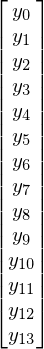

In [5]:
states

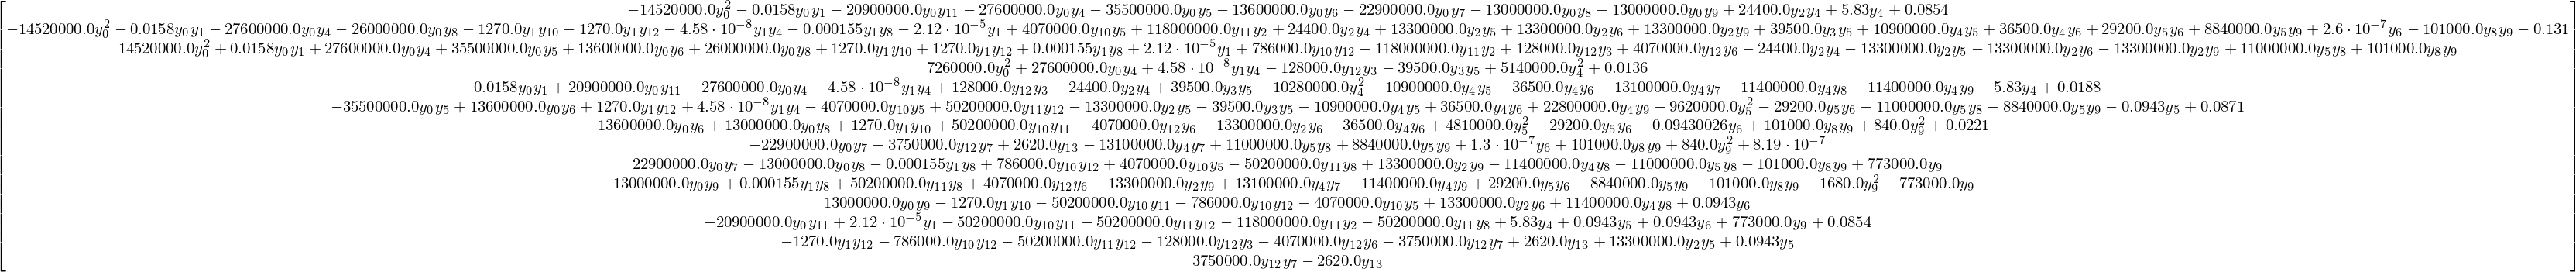

In [6]:
rhs_of_odes

In [7]:
type(rhs_of_odes)

sympy.matrices.dense.MutableDenseMatrix

In [8]:
rhs_of_odes.shape

In [9]:
type(states)

sympy.matrices.dense.MutableDenseMatrix

In [10]:
states.shape

The equations are nonlinear equations of the states. There are 14 equations and 14 states. The coefficients in the equations are various floating point numbers.

# Compute the Jacobian

As has been shown in the previous lesson the Jacobian of the right hand side of the differential equations is often very useful for computations, such as integration and optimization. With:

$$\frac{d\mathbf{y}}{dt} = \mathbf{f}(\mathbf{y})$$

the Jacobian is defined as:

$$\mathbf{J}(\mathbf{y}) = \frac{\partial\mathbf{f}(\mathbf{y})}{\partial\mathbf{y}}$$

SymPy can easily compute the Jacobian of matrix objects with the `Matrix.jacobian()` method.

## Exercise

Look up the Jacobian in the SymPy documentation then compute the Jacobian and store the result in the variable `jac_of_odes`. Inspect the resulting Jacobian for dimensionality, type, and the symbolic form.

In [11]:
jac_of_odes = rhs_of_odes.jacobian(states)

In [12]:
type(jac_of_odes)

sympy.matrices.dense.MutableDenseMatrix

In [13]:
jac_of_odes.shape

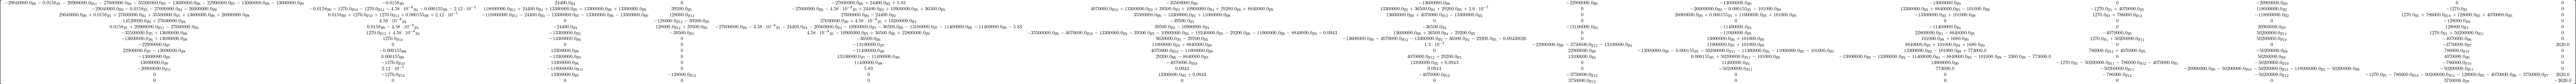

In [14]:
jac_of_odes

# C Code Printing

The two expressions are large and will likely have to be excuted many thousands of times to compute the desired numerical values, so we want them to execute as fast as possible. We can use SymPy to print these expressions as C code.

We will design a double precision C function that evaluates both $\mathbf{f}(\mathbf{y})$ and $\mathbf{J}(\mathbf{y})$ simultaneously given the values of the states $y$. Below is a basic template for a C program that can includes such a function. Our job is to populate the function with the SymPy expressions represented a C code.

```C
#include <math.h>
#include <stdio.h>

void evaluate_odes(const double state_vals[14], double rhs_result[14], double jac_result[196])
{
      // We need to fill in the code here using SymPy.
}

int main() {

    // initialize the state vector with some values
    double state_vals[14] = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14};
    // create "empty" 1D arrays to hold the results of the computation
    double rhs_result[14];
    double jac_result[196];
    
    // call the function
    evaluate_odes(state_vals, rhs_result, jac_result);
    
    // print the computed values to the terminal
    int i;

    printf("The right hand side of the equations evaluates to:\n");
    for (i=0; i < 14; i++) {
        printf("%lf\n", rhs_result[i]);
    }

    printf("\nThe Jacobian evaluates to:\n");
    for (i=0; i < 196; i++) {
        printf("%lf\n", jac_result[i]);
    }

    return 0;
}

```

Instead of using the `ccode` convenience function let's use the underlying code printer class to do the printing. This will allow us to modify the class to for custom printing further down.

In [15]:
from sympy.printing.ccode import C99CodePrinter

All printing classes have to be instantiated and then the `.doprint()` method can be used to print SymPy expressions. Let's try to print the right hand side of the differential equations.

In [16]:
printer = C99CodePrinter()

In [17]:
print(printer.doprint(rhs_of_odes))

// Not supported in C:
// ImmutableDenseMatrix
Matrix([
[                                                                                                                                                                                      -14520000.0*y0**2 - 0.0158*y0*y1 - 20900000.0*y0*y11 - 27600000.0*y0*y4 - 35500000.0*y0*y5 - 13600000.0*y0*y6 - 22900000.0*y0*y7 - 13000000.0*y0*y8 - 13000000.0*y0*y9 + 24400.0*y2*y4 + 5.83*y4 + 0.0854],
[-14520000.0*y0**2 - 0.0158*y0*y1 - 27600000.0*y0*y4 - 26000000.0*y0*y8 - 1270.0*y1*y10 - 1270.0*y1*y12 - 4.58e-8*y1*y4 - 0.000155*y1*y8 - 2.12e-5*y1 + 4070000.0*y10*y5 + 118000000.0*y11*y2 + 24400.0*y2*y4 + 13300000.0*y2*y5 + 13300000.0*y2*y6 + 13300000.0*y2*y9 + 39500.0*y3*y5 + 10900000.0*y4*y5 + 36500.0*y4*y6 + 29200.0*y5*y6 + 8840000.0*y5*y9 + 2.6e-7*y6 - 101000.0*y8*y9 - 0.131],
[                            14520000.0*y0**2 + 0.0158*y0*y1 + 27600000.0*y0*y4 + 35500000.0*y0*y5 + 13600000.0*y0*y6 + 26000000.0*y0*y8 + 1270.0*y1*y10 + 1270.0*y1*y12 +

In this case the C code printer does not do what we desire. It does not support printing a SymPy Matrix (see the first line of the output). In C, on possible representation of a matrix is an array type. The array type in C stores contigous values, e.g. doubles, in a chunk of memory. You can declare an array of doubles in C like:

```C
double my_array[10];
```

The word `double` is the data type of the individual values in the array which must all be the same. The word `my_array` is the variable name we choose to name the array and the `[10]` is the syntax to declare that this array will have 10 values.

The array is "empty" when first declared and can be filled with values like so:

```C
my_array[0] = 5;
my_array[1] = 6.78;
my array[2] = my_array[0] * 12;
```

or like:

```C
my_array = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10};
```

It is possible to declare multidimensional arrays in C that could map more directly to the indices of our two dimensional matrix, but in this case we will map our two dimensional matrix to a one dimenasional array using C contingous row ordering.

The code printers are capable of dealing with this need through the `assign_to` keyword argument in the `.doprint()` method but we must define a SymPy object that is appropriate to be assigned to. In our case, since we want to assign a Matrix we need to use an appropriately sized Matrix symbol.

In [18]:
rhs_result = sm.MatrixSymbol('rhs_result', 14, 1)

In [19]:
print(rhs_result)

rhs_result


In [20]:
print(printer.doprint(rhs_of_odes, assign_to=rhs_result))

rhs_result[0] = -14520000.0*pow(y0, 2) - 0.0158*y0*y1 - 20900000.0*y0*y11 - 27600000.0*y0*y4 - 35500000.0*y0*y5 - 13600000.0*y0*y6 - 22900000.0*y0*y7 - 13000000.0*y0*y8 - 13000000.0*y0*y9 + 24400.0*y2*y4 + 5.83*y4 + 0.0854;
rhs_result[1] = -14520000.0*pow(y0, 2) - 0.0158*y0*y1 - 27600000.0*y0*y4 - 26000000.0*y0*y8 - 1270.0*y1*y10 - 1270.0*y1*y12 - 4.58e-8*y1*y4 - 0.000155*y1*y8 - 2.12e-5*y1 + 4070000.0*y10*y5 + 118000000.0*y11*y2 + 24400.0*y2*y4 + 13300000.0*y2*y5 + 13300000.0*y2*y6 + 13300000.0*y2*y9 + 39500.0*y3*y5 + 10900000.0*y4*y5 + 36500.0*y4*y6 + 29200.0*y5*y6 + 8840000.0*y5*y9 + 2.6e-7*y6 - 101000.0*y8*y9 - 0.131;
rhs_result[2] = 14520000.0*pow(y0, 2) + 0.0158*y0*y1 + 27600000.0*y0*y4 + 35500000.0*y0*y5 + 13600000.0*y0*y6 + 26000000.0*y0*y8 + 1270.0*y1*y10 + 1270.0*y1*y12 + 0.000155*y1*y8 + 2.12e-5*y1 + 786000.0*y10*y12 - 118000000.0*y11*y2 + 128000.0*y12*y3 + 4070000.0*y12*y6 - 24400.0*y2*y4 - 13300000.0*y2*y5 - 13300000.0*y2*y6 - 13300000.0*y2*y9 + 11000000.0*y5*y8 + 101000.0

Notice that we have proper array value assignment and valid lines of C code that can be used in our function.

## Excercise

Print out valid C code from the Jacobian.

In [21]:
jac_result = sm.MatrixSymbol('jac_result', 14, 14)

In [22]:
print(jac_result)

jac_result


In [23]:
print(printer.doprint(jac_of_odes, assign_to=jac_result))

jac_result[0] = -29040000.0*y0 - 0.0158*y1 - 20900000.0*y11 - 27600000.0*y4 - 35500000.0*y5 - 13600000.0*y6 - 22900000.0*y7 - 13000000.0*y8 - 13000000.0*y9;
jac_result[1] = -0.0158*y0;
jac_result[2] = 24400.0*y4;
jac_result[3] = 0;
jac_result[4] = -27600000.0*y0 + 24400.0*y2 + 5.83;
jac_result[5] = -35500000.0*y0;
jac_result[6] = -13600000.0*y0;
jac_result[7] = -22900000.0*y0;
jac_result[8] = -13000000.0*y0;
jac_result[9] = -13000000.0*y0;
jac_result[10] = 0;
jac_result[11] = -20900000.0*y0;
jac_result[12] = 0;
jac_result[13] = 0;
jac_result[14] = -29040000.0*y0 - 0.0158*y1 - 27600000.0*y4 - 26000000.0*y8;
jac_result[15] = -0.0158*y0 - 1270.0*y10 - 1270.0*y12 - 4.58e-8*y4 - 0.000155*y8 - 2.12e-5;
jac_result[16] = 118000000.0*y11 + 24400.0*y4 + 13300000.0*y5 + 13300000.0*y6 + 13300000.0*y9;
jac_result[17] = 39500.0*y5;
jac_result[18] = -27600000.0*y0 - 4.58e-8*y1 + 24400.0*y2 + 10900000.0*y5 + 36500.0*y6;
jac_result[19] = 4070000.0*y10 + 13300000.0*y2 + 39500.0*y3 + 10900000.0*y4 + 2920

# Changing the Behavior of the Printer

The SymPy code printers are relatively easy to extend. They are designed such that if you want to change how a particularly SymPy object prints, for example a `Symbol`, then you only need to modify the `_print_Symbol` method. 

In [24]:
class MyCodePrinter(C99CodePrinter):
    def _print_Symbol(self, expr):
        return "No matter what symbol you pass in I will always print:\n\nNi!"

In [25]:
my_printer = MyCodePrinter()

In [26]:
print(my_printer.doprint(sm.Symbol('theta')))

No matter what symbol you pass in I will always print:

Ni!


# Exercise

It turns out that in C calling `pow()` for low exponents executes slower than simply expanding the multiplication. For example `pow(x, 2)` should be printed as `x*x`. Modify the CCodePrinter `._print_Pow` method to expand the multiplication if the exponent is less than or equal to 4. You may want to have a look at the source code with `printer._print_Pow??`

In [27]:
#printer._print_Pow??

In [28]:
class MyCodePrinter(C99CodePrinter):
    def _print_Pow(self, expr):
        if expr.exp > 0 and expr.exp <= 4:
            return '*'.join([self._print(expr.base) for i in range(expr.exp)])
        else:
            return super()._print_Pow(expr)

In [29]:
my_printer = MyCodePrinter()

In [30]:
x = sm.Symbol('x')
my_printer.doprint(x)

'x'

In [31]:
my_printer.doprint(x**2)

'x*x'

In [32]:
my_printer.doprint(x**4)

'x*x*x*x'

In [33]:
my_printer.doprint(x**5)

'pow(x, 5)'

## Exercise

One issue with our current code printer is that the expressions use the symbols `y0, y1, ..., y13` instead of accessing the values directly from the arrays with `y[0], y[1], ..., y[13]`. We could go back and rename our SymPy symbols to use brackets, but another way would be to override the `_print_Symbol()` method to print these symbols as we desire. Modify the code printer so that it prints with the proper array access in the expression.

In [34]:
state_vals = sm.MatrixSymbol('state_vals', 14, 1)

In [35]:
print(state_vals[0])

state_vals[0, 0]


In [36]:
class MyCodePrinter(C99CodePrinter):
    def _print_Symbol(self, expr):
        if expr in states:
            idx = list(states).index(expr)
            return self._print(state_vals[idx])

In [37]:
my_printer = MyCodePrinter()
print(my_printer.doprint(rhs_of_odes, assign_to=rhs_result))

rhs_result[0] = -14520000.0*pow(state_vals[0], 2) - 0.0158*state_vals[0]*state_vals[1] - 20900000.0*state_vals[0]*state_vals[11] - 27600000.0*state_vals[0]*state_vals[4] - 35500000.0*state_vals[0]*state_vals[5] - 13600000.0*state_vals[0]*state_vals[6] - 22900000.0*state_vals[0]*state_vals[7] - 13000000.0*state_vals[0]*state_vals[8] - 13000000.0*state_vals[0]*state_vals[9] + 24400.0*state_vals[2]*state_vals[4] + 5.83*state_vals[4] + 0.0854;
rhs_result[1] = -14520000.0*pow(state_vals[0], 2) - 0.0158*state_vals[0]*state_vals[1] - 27600000.0*state_vals[0]*state_vals[4] - 26000000.0*state_vals[0]*state_vals[8] - 1270.0*state_vals[1]*state_vals[10] - 1270.0*state_vals[1]*state_vals[12] - 4.58e-8*state_vals[1]*state_vals[4] - 0.000155*state_vals[1]*state_vals[8] - 2.12e-5*state_vals[1] + 4070000.0*state_vals[10]*state_vals[5] + 118000000.0*state_vals[11]*state_vals[2] + 24400.0*state_vals[2]*state_vals[4] + 13300000.0*state_vals[2]*state_vals[5] + 13300000.0*state_vals[2]*state_vals[6] + 1330

Or as mentioned you can replace the symbols up front. Notice that the C printer assumes that a 2D matrix will get mapped to a 1D C array.

In [38]:
state_array_map = dict(zip(states, state_vals))
print(state_array_map)

{y0: state_vals[0, 0], y1: state_vals[1, 0], y2: state_vals[2, 0], y3: state_vals[3, 0], y4: state_vals[4, 0], y5: state_vals[5, 0], y6: state_vals[6, 0], y7: state_vals[7, 0], y8: state_vals[8, 0], y9: state_vals[9, 0], y10: state_vals[10, 0], y11: state_vals[11, 0], y12: state_vals[12, 0], y13: state_vals[13, 0]}


In [39]:
print(printer.doprint(rhs_of_odes.xreplace(state_array_map), assign_to=rhs_result))

rhs_result[0] = -14520000.0*pow(state_vals[0], 2) - 0.0158*state_vals[0]*state_vals[1] - 27600000.0*state_vals[0]*state_vals[4] - 35500000.0*state_vals[0]*state_vals[5] - 13600000.0*state_vals[0]*state_vals[6] - 22900000.0*state_vals[0]*state_vals[7] - 13000000.0*state_vals[0]*state_vals[8] - 13000000.0*state_vals[0]*state_vals[9] - 20900000.0*state_vals[0]*state_vals[11] + 24400.0*state_vals[2]*state_vals[4] + 5.83*state_vals[4] + 0.0854;
rhs_result[1] = -14520000.0*pow(state_vals[0], 2) - 0.0158*state_vals[0]*state_vals[1] - 27600000.0*state_vals[0]*state_vals[4] - 26000000.0*state_vals[0]*state_vals[8] - 4.58e-8*state_vals[1]*state_vals[4] - 0.000155*state_vals[1]*state_vals[8] - 1270.0*state_vals[1]*state_vals[10] - 1270.0*state_vals[1]*state_vals[12] - 2.12e-5*state_vals[1] + 24400.0*state_vals[2]*state_vals[4] + 13300000.0*state_vals[2]*state_vals[5] + 13300000.0*state_vals[2]*state_vals[6] + 13300000.0*state_vals[2]*state_vals[9] + 118000000.0*state_vals[2]*state_vals[11] + 3950

# Common Subexpression Elimination

If you look carefully at the expressions in the two matrices you'll see repeated expressions. These are not ideal in the sense that the computer has to repeat the exact same calculation multiple times. For large expressions this can be a major issue. Compilers, such as gcc, can often eliminate common subexpressions on their own when different optimization flags are invoked but for complex expressions the algorithms in some compilers do not do a thorough job or compilation can take an extremely long time. SymPy has tools to perform common subexpression elimination which is both thorough and reasonably efficient. In particular if gcc is run with the lowest optimization setting `-O0` cse can give large speedups.

For example if you have two expressions:

```python
a = x*y + 5
b = x*y + 6
```

you can convert this to these three expressions:

```python
z = x*y
a = z + 5
b = z + 6
```

and `x*y` only has to be computed once.

The `cse()` function in SymPy returns the subexpression, `z = x*y`, and the simplified expressions: `a = z + 5`, `b = z + 6`.

Here is how it works:

In [40]:
sub_exprs, simplified_rhs = sm.cse(rhs_of_odes)

In [41]:
for var, expr in sub_exprs:
    sm.pprint(sm.Eq(var, expr))

x₀ = 0.0158⋅y₀⋅y₁
x₁ = -x₀
x₂ = 27600000.0⋅y₀⋅y₄
x₃ = -x₂
x₄ = 24400.0⋅y₂⋅y₄
       2
x₅ = y₀ 
x₆ = 14520000.0⋅x₅
x₇ = -x₆
x₈ = 5.83⋅y₄
x₉ = 20900000.0⋅y₀⋅y₁₁
x₁₀ = -x₉
x₁₁ = 35500000.0⋅y₀⋅y₅
x₁₂ = -x₁₁
x₁₃ = 13600000.0⋅y₀⋅y₆
x₁₄ = -x₁₃
x₁₅ = 22900000.0⋅y₀⋅y₇
x₁₆ = -x₁₅
x₁₇ = y₀⋅y₈
x₁₈ = 13000000.0⋅x₁₇
x₁₉ = -x₁₈
x₂₀ = 13000000.0⋅y₀⋅y₉
x₂₁ = -x₂₀
x₂₂ = 4.58e-8⋅y₁⋅y₄
x₂₃ = 39500.0⋅y₃⋅y₅
x₂₄ = -x₂₂ + x₂₃
x₂₅ = 2.12e-5⋅y₁
x₂₆ = 26000000.0⋅x₁₇
x₂₇ = 1270.0⋅y₁
x₂₈ = x₂₇⋅y₁₀
x₂₉ = -x₂₈
x₃₀ = x₂₇⋅y₁₂
x₃₁ = -x₃₀
x₃₂ = 0.000155⋅y₁⋅y₈
x₃₃ = -x₃₂
x₃₄ = 4070000.0⋅y₁₀⋅y₅
x₃₅ = 118000000.0⋅y₁₁⋅y₂
x₃₆ = 13300000.0⋅y₂
x₃₇ = x₃₆⋅y₅
x₃₈ = x₃₆⋅y₆
x₃₉ = x₃₆⋅y₉
x₄₀ = 10900000.0⋅y₄⋅y₅
x₄₁ = 36500.0⋅y₄⋅y₆
x₄₂ = 29200.0⋅y₅⋅y₆
x₄₃ = 8840000.0⋅y₅⋅y₉
x₄₄ = 101000.0⋅y₈⋅y₉
x₄₅ = -x₄₄
x₄₆ = x₁₃ + x₃₀ - x₃₇
x₄₇ = 786000.0⋅y₁₀⋅y₁₂
x₄₈ = -x₃₅
x₄₉ = 128000.0⋅y₁₂⋅y₃
x₅₀ = 4070000.0⋅y₁₂⋅y₆
x₅₁ = -x₄
x₅₂ = -x₃₈
x₅₃ = -x₃₉
x₅₄ = 11000000.0⋅y₅⋅y₈
x₅₅ = -x₂₃
x₅₆ = -x₄₉
        2
x₅₇ = y₄ 
x₅₈ = -x₄₀
x₅₉ = -x₄₁
x₆₀ = 13100000

`cse()` can return a number of simplified expressions and to do this it returns a list. In our case we have 1 simplified expression that can be accessed as the first item of the list.

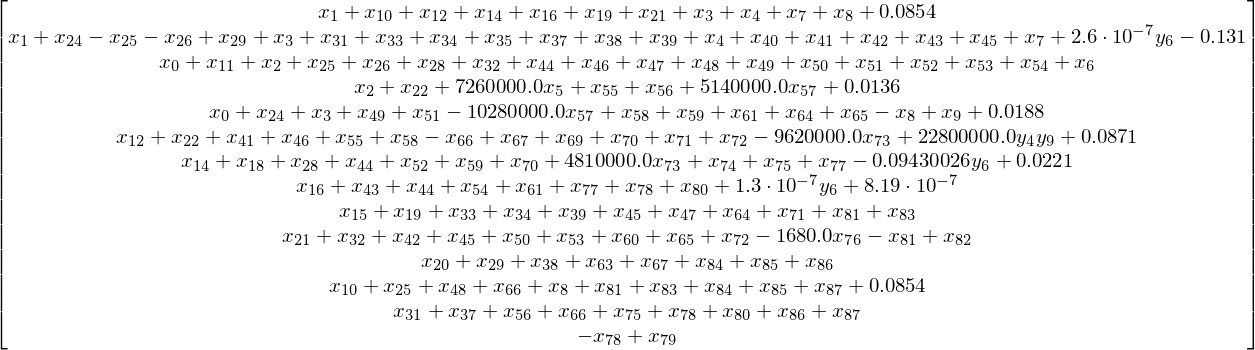

In [42]:
simplified_rhs[0]

You can find common subexpressions among multiple objects also:

In [43]:
sub_exprs, simplified_exprs = sm.cse((rhs_of_odes, jac_of_odes))

In [44]:
for var, expr in sub_exprs:
    sm.pprint(sm.Eq(var, expr))

x₀ = 0.0158⋅y₀
x₁ = x₀⋅y₁
x₂ = -x₁
x₃ = 27600000.0⋅y₀
x₄ = x₃⋅y₄
x₅ = -x₄
x₆ = 24400.0⋅y₂
x₇ = x₆⋅y₄
       2
x₈ = y₀ 
x₉ = 14520000.0⋅x₈
x₁₀ = -x₉
x₁₁ = 5.83⋅y₄
x₁₂ = 20900000.0⋅y₀
x₁₃ = x₁₂⋅y₁₁
x₁₄ = -x₁₃
x₁₅ = 35500000.0⋅y₀
x₁₆ = x₁₅⋅y₅
x₁₇ = -x₁₆
x₁₈ = 13600000.0⋅y₀
x₁₉ = x₁₈⋅y₆
x₂₀ = -x₁₉
x₂₁ = 22900000.0⋅y₀
x₂₂ = x₂₁⋅y₇
x₂₃ = -x₂₂
x₂₄ = 13000000.0⋅y₀
x₂₅ = x₂₄⋅y₈
x₂₆ = -x₂₅
x₂₇ = x₂₄⋅y₉
x₂₈ = -x₂₇
x₂₉ = 4.58e-8⋅y₁
x₃₀ = x₂₉⋅y₄
x₃₁ = 39500.0⋅y₃
x₃₂ = x₃₁⋅y₅
x₃₃ = -x₃₀ + x₃₂
x₃₄ = 2.12e-5⋅y₁
x₃₅ = 26000000.0⋅y₀
x₃₆ = x₃₅⋅y₈
x₃₇ = 1270.0⋅y₁
x₃₈ = x₃₇⋅y₁₀
x₃₉ = -x₃₈
x₄₀ = x₃₇⋅y₁₂
x₄₁ = -x₄₀
x₄₂ = 0.000155⋅y₁
x₄₃ = x₄₂⋅y₈
x₄₄ = -x₄₃
x₄₅ = 4070000.0⋅y₁₀
x₄₆ = x₄₅⋅y₅
x₄₇ = 118000000.0⋅y₁₁
x₄₈ = x₄₇⋅y₂
x₄₉ = 13300000.0⋅y₂
x₅₀ = x₄₉⋅y₅
x₅₁ = x₄₉⋅y₆
x₅₂ = x₄₉⋅y₉
x₅₃ = 10900000.0⋅y₄
x₅₄ = x₅₃⋅y₅
x₅₅ = 36500.0⋅y₄
x₅₆ = x₅₅⋅y₆
x₅₇ = 29200.0⋅y₅
x₅₈ = x₅₇⋅y₆
x₅₉ = 8840000.0⋅y₅
x₆₀ = x₅₉⋅y₉
x₆₁ = 101000.0⋅y₈
x₆₂ = x₆₁⋅y₉
x₆₃ = -x₆₂
x₆₄ = x₁₉ + x₄₀ - x₅₀
x₆₅ = 786000.0⋅y₁₀
x₆₆ = x₆₅⋅y₁₂
x₆₇ = -x₄

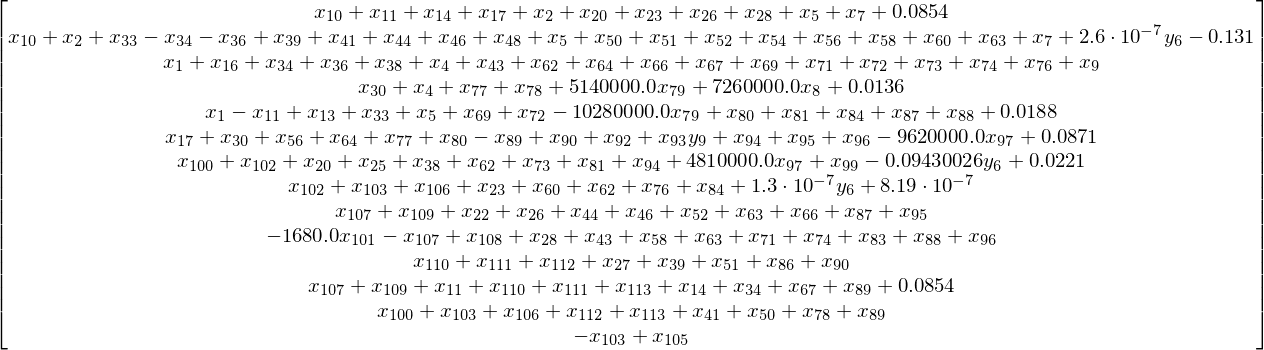

In [45]:
simplified_exprs[0]

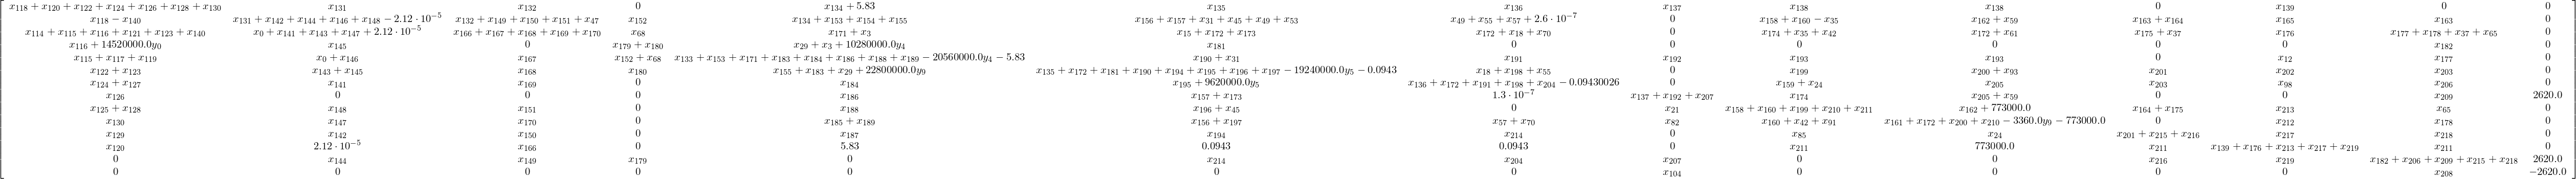

In [46]:
simplified_exprs[1]

# Exercise

Use common subexpression elimination to print out C code for your two arrays such that:

```C
double x0 = some_sub_expression;
...
double xN = the_last_sub_expression;

rhs_result[0] = expressions_containing_the_subexpressions;
...
rhs_result[13] = ...;

jac_result[0] = ...;
...
jac_result[195] = ...;
```

This code can be copied and pasted into the provided template above to make a C program.

You can add in cse fairly easily for printing a single matrix:

In [47]:
from sympy.printing.codeprinter import Assignment

class CMatrixPrinter(C99CodePrinter):
    def _print_ImmutableDenseMatrix(self, expr):
        sub_exprs, simplified = sm.cse(expr)
        lines = []
        for var, sub_expr in sub_exprs:
            lines.append('double ' + self._print(Assignment(var, sub_expr)))
        M = sm.MatrixSymbol('M', *expr.shape)
        return '\n'.join(lines) + '\n' + self._print(Assignment(M, expr))

In [48]:
p = CMatrixPrinter()
print(p.doprint(jac_of_odes))

double x0 = 29040000.0*y0;
double x1 = 0.0158*y1;
double x2 = 27600000.0*y4;
double x3 = -x2;
double x4 = -x0 - x1 + x3;
double x5 = 20900000.0*y11;
double x6 = -x5;
double x7 = 35500000.0*y5;
double x8 = -x7;
double x9 = 13600000.0*y6;
double x10 = -x9;
double x11 = 22900000.0*y7;
double x12 = -x11;
double x13 = 13000000.0*y8;
double x14 = -x13;
double x15 = 13000000.0*y9;
double x16 = -x15;
double x17 = 0.0158*y0;
double x18 = -x17;
double x19 = 24400.0*y4;
double x20 = 27600000.0*y0;
double x21 = -x20;
double x22 = 24400.0*y2;
double x23 = x21 + x22;
double x24 = 35500000.0*y0;
double x25 = -x24;
double x26 = 13600000.0*y0;
double x27 = -x26;
double x28 = 22900000.0*y0;
double x29 = -x28;
double x30 = 13000000.0*y0;
double x31 = -x30;
double x32 = 20900000.0*y0;
double x33 = -x32;
double x34 = 26000000.0*y8;
double x35 = 1270.0*y10;
double x36 = -x35;
double x37 = 1270.0*y12;
double x38 = -x37;
double x39 = 4.58e-8*y4;
double x40 = -x39;
double x41 = 0.000155*y8;
double x42 = -x41;


In [49]:
class CMatrixPrinter(C99CodePrinter):
    
    def _print_list(self, list_of_exprs):
        # NOTE : The MutableDenseMatrix is turned in an ImmutableMatrix inside here.
        if all(isinstance(x, sm.ImmutableMatrix) for x in list_of_exprs):
            sub_exprs, simplified_exprs = sm.cse(list_of_exprs)
            lines = []
            for var, sub_expr in sub_exprs:
                ass = Assignment(var, sub_expr.xreplace(state_array_map))
                lines.append('double ' + self._print(ass))
            for mat in simplified_exprs:
                lines.append(self._print(mat.xreplace(state_array_map)))
            return '\n'.join(lines)
        else:
            return super()._print_list(list_of_exprs)
            
    def _print_ImmutableDenseMatrix(self, expr):
        if expr.shape[1] > 1:
            M = sm.MatrixSymbol('jac_result', *expr.shape)
        else:
            M = sm.MatrixSymbol('rhs_result', *expr.shape)
        return self._print(Assignment(M, expr))

In [50]:
p = CMatrixPrinter()
print(p.doprint([rhs_of_odes, jac_of_odes]))

double x0 = 0.0158*state_vals[0];
double x1 = x0*state_vals[1];
double x2 = -x1;
double x3 = 27600000.0*state_vals[0];
double x4 = x3*state_vals[4];
double x5 = -x4;
double x6 = 24400.0*state_vals[2];
double x7 = x6*state_vals[4];
double x8 = pow(state_vals[0], 2);
double x9 = 14520000.0*x8;
double x10 = -x9;
double x11 = 5.83*state_vals[4];
double x12 = 20900000.0*state_vals[0];
double x13 = x12*state_vals[11];
double x14 = -x13;
double x15 = 35500000.0*state_vals[0];
double x16 = x15*state_vals[5];
double x17 = -x16;
double x18 = 13600000.0*state_vals[0];
double x19 = x18*state_vals[6];
double x20 = -x19;
double x21 = 22900000.0*state_vals[0];
double x22 = x21*state_vals[7];
double x23 = -x22;
double x24 = 13000000.0*state_vals[0];
double x25 = x24*state_vals[8];
double x26 = -x25;
double x27 = x24*state_vals[9];
double x28 = -x27;
double x29 = 4.58e-8*state_vals[1];
double x30 = x29*state_vals[4];
double x31 = 39500.0*state_vals[3];
double x32 = x31*state_vals[5];
double x33 = -x30 

# Bonus: Compile and Run the C Program

In [51]:
c_template = """\
#include <math.h>
#include <stdio.h>

void evaluate_odes(const double state_vals[14], double rhs_result[14], double jac_result[196])
{{
    // We need to fill in the code here using SymPy.
{code}
}}

int main() {{

    // initialize the state vector with some values
    double state_vals[14] = {{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}};
    // create "empty" 1D arrays to hold the results of the computation
    double rhs_result[14];
    double jac_result[196];

    // call the function
    evaluate_odes(state_vals, rhs_result, jac_result);

    // print the computed values to the terminal
    int i;
    printf("The right hand side of the equations evaluates to:\\n");
    for (i=0; i < 14; i++) {{
        printf("%lf\\n", rhs_result[i]);
    }}
    printf("\\nThe Jacobian evaluates to:\\n");
    for (i=0; i < 196; i++) {{
        printf("%lf\\n", jac_result[i]);
    }}

    return 0;
}}\
"""

In [52]:
c_program = c_template.format(code=p.doprint([rhs_of_odes, jac_of_odes]))
print(c_program)

#include <math.h>
#include <stdio.h>

void evaluate_odes(const double state_vals[14], double rhs_result[14], double jac_result[196])
{
    // We need to fill in the code here using SymPy.
double x0 = 0.0158*state_vals[0];
double x1 = x0*state_vals[1];
double x2 = -x1;
double x3 = 27600000.0*state_vals[0];
double x4 = x3*state_vals[4];
double x5 = -x4;
double x6 = 24400.0*state_vals[2];
double x7 = x6*state_vals[4];
double x8 = pow(state_vals[0], 2);
double x9 = 14520000.0*x8;
double x10 = -x9;
double x11 = 5.83*state_vals[4];
double x12 = 20900000.0*state_vals[0];
double x13 = x12*state_vals[11];
double x14 = -x13;
double x15 = 35500000.0*state_vals[0];
double x16 = x15*state_vals[5];
double x17 = -x16;
double x18 = 13600000.0*state_vals[0];
double x19 = x18*state_vals[6];
double x20 = -x19;
double x21 = 22900000.0*state_vals[0];
double x22 = x21*state_vals[7];
double x23 = -x22;
double x24 = 13000000.0*state_vals[0];
double x25 = x24*state_vals[8];
double x26 = -x25;
double x27 = x24*

In [53]:
with open('run.c', 'w') as f:
    f.write(c_program)

To compile the code there are several options. The first is gcc (the GNU C Compiler). If you have Linux, Mac, or Windows (w/ mingw installed) you can use the Jupyter notebook `!` command to send your command to the terminal. For example:

```ipython
!gcc run.c -lm -o run
```

This will compile `run.c`, link against the C math library with `-lm` and output, `-o`, to a file `run` (Mac/Linux) or `run.exe` (Windows).

On Mac and Linux the program can be executed with:

```ipython
!./run
```

and on Windows:

```ipython
!run.exe
```

Other options are using the clang compiler or Windows cl:

```ipython
!clang run.c -lm -o run
!cl run.c -lm
```